## Описание данных

Данные о постах хранятся в двух файлах идентичного формата: train_content.csv и test_content.csv.

Эти файлы имеют следующие поля, разделенные пробелами:

<b>group_id</b> - Анонимизированный идентификатор группы, в которой размещен пост<br/>
<b>post_id</b> - Анонимизированный идентификатор поста<br/>
<b>timestamp</b> - Время публикации поста, представляющее собой количество миллисекунд, прошедшее с полночи 1-го января 1970 года (UTC).<br/>
<b>content</b> - Содержание поста. Внимание: в этом поле могут содержаться пробелы, специальные символы, а также http-ссылки, изображения и опросы. Авторская орфография и пунктуация сохранены.
    


С помощью потрясающей магии командной строки я покажу что в этих данных находится итак...

find, xargs, head... ну в смысле man find, man xars:

find ./ -name "*.csv" -print | xargs head



==> ./data/train_ids.csv <==<br/>
1<br/>
2<br/>

==> ./data/test_content.csv <==<br/>
1	3	1238498025437	Создадим общий вес нашей группы....? <br/>
1	5	1347079402987	Сегодня именинница - Наташа. Найдется ли ее милей и краше, Надежней и настойчивей в делах ? Она в заботах, как пчела в цветах ! Достичь признанья - главное стремленье, Чтоб вызвать и восторг, и удивленье. Хвала Наталье стимул придает, Чтоб энергичней двигаться вперед. В день ангела Наташеньку поздравим ! За все дела - на сто ладов расхвалим И подчеркнем, как нрав ее нам мил, - Пускай придаст ей это новых сил ! Наталья, от души тебе желаем: Успех во всем пусть будет нескончаем, Во всех делах имей свой интерес И будь хранимой ангелом с небес 
<br/>
==> ./data/train_likes.csv <==<br/>
1	489105	1381985679323<br/>
2	581857	1375185930650<br/>

==> ./data/train_likes_count.csv <==<br/>
"post_id","likes"<br/>
1,0<br/>

==> ./data/test_ids.csv <==<br/>
3<br/>
5<br/>

==> ./data/train_content.csv <==<br/>
1	1	1215772521477	Играем в города !!! <br/>
1	2	1368036207488	Мы Наташки-Очаровашки!!!!:-) <br/>

## Предварительный анализ / Exploratory Analysis

Вся соль в том, как обработать содержание поста и какие характеристики для него можно придумать. Поэтому начнём с того, что посмотрим какие посты вобще тут бывают.

Размер всего набора данных:
<strong>$ cat train_content.csv |wc -l</strong>
519872

Чтобы лишний раз не гонять по памяти туда-сюда, возьмём 20% от обучающей выборки, чтобы посмотреть какие посты бывают:
<strong>$ cat train_content.csv |head -100000 > train_content_explore.csv</strong>


In [2]:
import pandas as pd
import re

#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

#добавим encoding, чтобы данные считывались в utf-8
posts = pd.read_csv('./data/train.tsv',encoding='utf-8', sep="\t")
posts.head()
        

,post_id,text,date,num_comments,num_likes,num_reposts,attachment_types
0,152543,Шутка вечера.,2015-05-01 23:55:45,27,255,29,"photo,link"
1,152532,Организатор монстрации в Новосибирске задержан...,2015-05-01 23:00:50,1,105,22,"photo,link"
2,152497,Интересное статистическое сравнение жизни обыч...,2015-05-01 21:00:17,5,59,16,"photo,link"
3,152485,"Моим первым постом в «Команде» был пост о том,...",2015-05-01 20:01:05,8,104,18,photo
4,152463,Коуб с сегодняшним Милоновым. Оригинал - https...,2015-05-01 19:00:57,10,40,0,video


Посмотрим на данные в общем. Точнее, подозревая единственную неприятную вещь в пайтоне, юникод... Проверим что же нам выдаст:

In [3]:
pattern = re.compile(ur'\w+', re.UNICODE)
print posts.text[2],' length: ', len(pattern.findall(posts.text[2]))

Интересное статистическое сравнение жизни обычного жителя России и такого же обычного жителя стран Запада. Основные вехи жизни в цифрах: от рождения до смерти.  length:  23


In [11]:
posts['num_of_chars']=posts['text'].apply(lambda x: len(unicode(x)))
posts['num_of_words']=posts['text'].apply(lambda x: len(pattern.findall(unicode(x))))
posts['num_of_textblocks']=posts['text'].apply(lambda x: len(unicode(x).split(' ')))
posts['avg_word_length']=posts.num_of_chars / posts.num_of_words
posts.head()

,post_id,text,date,num_comments,num_likes,num_reposts,attachment_types,num_of_chars,num_of_words,num_of_textblocks,avg_word_length
0,152543,Шутка вечера.,2015-05-01 23:55:45,27,255,29,"photo,link",13,2,2,6.500000
1,152532,Организатор монстрации в Новосибирске задержан...,2015-05-01 23:00:50,1,105,22,"photo,link",131,17,16,7.705882
2,152497,Интересное статистическое сравнение жизни обыч...,2015-05-01 21:00:17,5,59,16,"photo,link",159,23,23,6.913043
3,152485,"Моим первым постом в «Команде» был пост о том,...",2015-05-01 20:01:05,8,104,18,photo,219,39,41,5.615385
4,152463,Коуб с сегодняшним Милоновым. Оригинал - https...,2015-05-01 19:00:57,10,40,0,video,84,12,7,7.000000


In [31]:
posts['text'][pd.isnull(posts.text)] = ""

/Users/oruen/apps/my/bigdata/lab4/venv/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [46]:
posts.describe()

,post_id,num_comments,num_likes,num_reposts,num_of_chars,num_of_words,num_of_textblocks,avg_word_length,has_question_mark,number_exclamation_mark,number_of_images,has_link,has_external_link,has_video,num_of_uppercase_letters,capital_letters_ratio,num_of_lowercase_letters,hour
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457,457.000000,457,457,457,457,457.000000,457.000000,457.000000,457.000000
mean,148315.393873,14.689278,102.601751,20.940919,222.851204,31.113786,30.459519,7.191847,0.07002188,0.091904,0,0.05908096,0.8949672,0.04157549,6.542670,0.032672,176.448578,14.947484
std,2471.698595,19.507639,65.327540,18.086016,127.487959,18.362581,17.730531,0.995605,0.2554635,0.363161,0,0.2360346,0.3069317,0.1998358,4.885401,0.025313,101.058402,6.135305
min,143865.000000,0.000000,16.000000,0.000000,3.000000,1.000000,1.000000,3.000000,False,0.000000,0,False,False,False,0.000000,0.000000,0.000000,0.000000
25%,146147.000000,5.000000,58.000000,10.000000,127.000000,17.000000,17.000000,6.666667,0,0.000000,0,0,1,0,3.000000,0.018450,100.000000,11.000000
50%,148447.000000,10.000000,86.000000,16.000000,217.000000,30.000000,29.000000,7.157895,0,0.000000,0,0,1,0,5.000000,0.028369,171.000000,16.000000
75%,150322.000000,18.000000,130.000000,26.000000,297.000000,41.000000,41.000000,7.724138,0,0.000000,0,0,1,0,8.000000,0.038567,240.000000,20.000000
max,152543.000000,238.000000,472.000000,164.000000,935.000000,140.000000,128.000000,11.000000,True,3.000000,0,True,True,True,47.000000,0.319728,736.000000,23.000000


In [33]:
print posts.text[posts.text.str.contains('http')][:5]
print '\n Количество постов с ссылками: ',len (posts.text[posts.text.str.contains('http')])

4      Коуб с сегодняшним Милоновым. Оригинал - https...
38     Работа в регионах начинается! Нам нужны волонт...
41     Парламент Никарагуа ратифицировал договор с Ро...
91     5-летие "Дождя". Лучший телеканал России. Шнур...
144    Кадыров приказал стрелять в любых силовиков (х...
Name: text, dtype: object

 Количество постов с ссылками:  27


In [36]:
print posts.text[posts.attachment_types.str.contains('photo')][:5]
print '\n Количество постов с изображениями: ',len (posts.text[posts.attachment_types.str.contains('photo')])
print posts.text[posts.attachment_types.str.contains('link')][:5]
print '\n Количество постов с ссылками: ',len (posts.text[posts.attachment_types.str.contains('link')])
print posts.text[posts.attachment_types.str.contains('video')][:5]
print '\n Количество постов с видео: ',len (posts.text[posts.attachment_types.str.contains('video')])

0                                        Шутка вечера.
1    Организатор монстрации в Новосибирске задержан...
2    Интересное статистическое сравнение жизни обыч...
3    Моим первым постом в «Команде» был пост о том,...
5    Кобзон займется развитием стрельбы из лука в Р...
Name: text, dtype: object

 Количество постов с изображениями:  437
0                                        Шутка вечера.
1    Организатор монстрации в Новосибирске задержан...
2    Интересное статистическое сравнение жизни обыч...
5    Кобзон займется развитием стрельбы из лука в Р...
6    С 1 мая вступила в силу более жёсткая версия а...
Name: text, dtype: object

 Количество постов с ссылками:  409
4      Коуб с сегодняшним Милоновым. Оригинал - https...
32     Басманный суд Москвы санкционировал заочный ар...
50     Вначале байкеров из клуба «Ночные волки» не пу...
55     «Открытая Россия» подготовила альтернативный в...
100    Квартиры к 70-летию Победы не будет. В селе Ос...
Name: text, dtype: object

 Количе

In [39]:
posts['has_question_mark'] = posts.text.str.contains('([\?]{1})')
posts['number_exclamation_mark'] = posts.text.str.count('([!]{1})')
posts['has_link'] = posts.text.str.contains('http')
posts['has_external_link'] = posts.attachment_types.str.contains('link')
posts['has_video'] = posts.attachment_types.str.contains('video')
posts['num_of_uppercase_letters'] = posts.text.str.count(u'[A-ZА-ЯЁ]{1}')
posts['num_of_lowercase_letters'] = posts.text.str.count(u'[a-zа-яё]{1}')
posts['capital_letters_ratio'] = posts.num_of_uppercase_letters / posts.num_of_chars

In [40]:
posts[['has_question_mark','number_exclamation_mark','has_link','has_external_link','has_video','num_of_uppercase_letters','num_of_lowercase_letters','capital_letters_ratio']].describe()

,has_question_mark,number_exclamation_mark,has_link,has_external_link,has_video,num_of_uppercase_letters,num_of_lowercase_letters,capital_letters_ratio
count,457,457.000000,457,457,457,457.000000,457.000000,457.000000
mean,0.07002188,0.091904,0.05908096,0.8949672,0.04157549,6.542670,176.448578,0.032672
std,0.2554635,0.363161,0.2360346,0.3069317,0.1998358,4.885401,101.058402,0.025313
min,False,0.000000,False,False,False,0.000000,0.000000,0.000000
25%,0,0.000000,0,1,0,3.000000,100.000000,0.018450
50%,0,0.000000,0,1,0,5.000000,171.000000,0.028369
75%,0,0.000000,0,1,0,8.000000,240.000000,0.038567
max,True,3.000000,True,True,True,47.000000,736.000000,0.319728


In [44]:
from datetime import datetime, date, time

print posts.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d %H:%M:%S"))[:5]
print posts.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d %H:%M:%S").hour)[:5]

posts['hour']=posts.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d %H:%M:%S").hour)

0   2015-05-01 23:55:45
1   2015-05-01 23:00:50
2   2015-05-01 21:00:17
3   2015-05-01 20:01:05
4   2015-05-01 19:00:57
Name: date, dtype: datetime64[ns]
0    23
1    23
2    21
3    20
4    19
Name: date, dtype: int64


In [49]:
posts.describe()

,post_id,num_comments,num_likes,num_reposts,num_of_chars,num_of_words,num_of_textblocks,avg_word_length,has_question_mark,number_exclamation_mark,number_of_images,has_link,has_external_link,has_video,num_of_uppercase_letters,capital_letters_ratio,num_of_lowercase_letters,hour
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457,457.000000,457,457,457,457,457.000000,457.000000,457.000000,457.000000
mean,148315.393873,14.689278,102.601751,20.940919,222.851204,31.113786,30.459519,7.191847,0.07002188,0.091904,0,0.05908096,0.8949672,0.04157549,6.542670,0.032672,176.448578,14.947484
std,2471.698595,19.507639,65.327540,18.086016,127.487959,18.362581,17.730531,0.995605,0.2554635,0.363161,0,0.2360346,0.3069317,0.1998358,4.885401,0.025313,101.058402,6.135305
min,143865.000000,0.000000,16.000000,0.000000,3.000000,1.000000,1.000000,3.000000,False,0.000000,0,False,False,False,0.000000,0.000000,0.000000,0.000000
25%,146147.000000,5.000000,58.000000,10.000000,127.000000,17.000000,17.000000,6.666667,0,0.000000,0,0,1,0,3.000000,0.018450,100.000000,11.000000
50%,148447.000000,10.000000,86.000000,16.000000,217.000000,30.000000,29.000000,7.157895,0,0.000000,0,0,1,0,5.000000,0.028369,171.000000,16.000000
75%,150322.000000,18.000000,130.000000,26.000000,297.000000,41.000000,41.000000,7.724138,0,0.000000,0,0,1,0,8.000000,0.038567,240.000000,20.000000
max,152543.000000,238.000000,472.000000,164.000000,935.000000,140.000000,128.000000,11.000000,True,3.000000,0,True,True,True,47.000000,0.319728,736.000000,23.000000


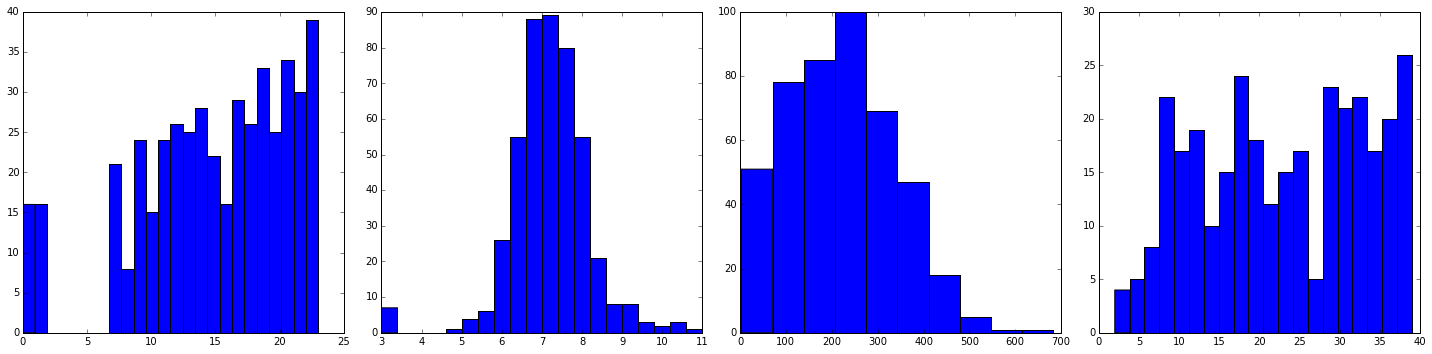

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes=plt.subplots(figsize=(20,5), nrows=1, ncols=4)
axes[0].hist(posts.hour,bins=24)
axes[1].hist(posts.avg_word_length[(posts.avg_word_length>1) & (posts.avg_word_length<20)],bins=20)
axes[2].hist(posts.num_of_chars[(posts.num_of_chars>2) & (posts.num_of_chars<800)])
axes[3].hist(posts.num_of_words[(posts.num_of_words>1) & (posts.num_of_words<40)], bins=20)

fig.tight_layout()

In [64]:
training_set = posts
training_set.head()

,post_id,text,date,num_comments,num_likes,num_reposts,attachment_types,num_of_chars,num_of_words,num_of_textblocks,avg_word_length,has_question_mark,number_exclamation_mark,number_of_images,has_link,has_external_link,has_video,num_of_uppercase_letters,capital_letters_ratio,num_of_lowercase_letters,hour
0,152543,Шутка вечера.,2015-05-01 23:55:45,27,255,29,"photo,link",13,2,2,6.500000,False,0,0,False,True,False,1,0.076923,10,23
1,152532,Организатор монстрации в Новосибирске задержан...,2015-05-01 23:00:50,1,105,22,"photo,link",131,17,16,7.705882,False,1,0,False,True,False,5,0.038168,101,23
2,152497,Интересное статистическое сравнение жизни обыч...,2015-05-01 21:00:17,5,59,16,"photo,link",159,23,23,6.913043,False,0,0,False,True,False,4,0.025157,130,21
3,152485,"Моим первым постом в «Команде» был пост о том,...",2015-05-01 20:01:05,8,104,18,photo,219,39,41,5.615385,False,0,0,False,False,False,9,0.041096,162,20
4,152463,Коуб с сегодняшним Милоновым. Оригинал - https...,2015-05-01 19:00:57,10,40,0,video,84,12,7,7.000000,True,0,0,True,False,True,10,0.119048,58,19


In [65]:
features = ['num_of_chars','num_of_words','avg_word_length','hour']
training_set[features].corr()

,num_of_chars,num_of_words,avg_word_length,hour
num_of_chars,1.000000,0.984216,0.076481,-0.000251
num_of_words,0.984216,1.000000,-0.050126,-0.012852
avg_word_length,0.076481,-0.050126,1.000000,-0.012510
hour,-0.000251,-0.012852,-0.012510,1.000000


In [67]:
#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 1000)
training_set.sort(columns=['num_likes'],ascending=False)[:100][['text','num_likes']]

,text,num_likes
160,"Власть обнаружила, что фильтры Роскомнадзора легко обойти, и занялась разработкой файрвола с более широкими возможностями, на который понадобятся миллиарды рублей. В стране алкоголизм, наркомания, безработица, куча нищих. А они вбухивают миллиарды в борьбу с интернет-страничками.",472
108,,465
205,"Россия поможет Греции с ее долгами, выделив 5 млрд евро.",454
395,"Долго смеялись над этим видео, решили вам тоже показать ) Сюжет о Навальном на северокорейском телевидении (перевод Бочарова):",348
37,"По адресу, где располагается Храм Христа Спасителя, зарегистрировано 26 юридических лиц, следует из информации, размещенной на сайте ФНС. Ругать церковь по их просьбе нельзя, поэтому без комментариев, просто как факт.",315
302,"Конструктор Сергей Королёв — человек, благодаря которому СССР покорил космос. Однако от сталинских репрессий не уберегал даже талант. Королёва пытали, сломали обе челюсти и отправили на прииск Мальдяк в Магаданской области. В День космонавтики вспомним историю жизни великого человека.",314
91,"5-летие ""Дождя"". Лучший телеканал России. Шнур дает отличный концерт. #дождь #5лет https://instagram.com/p/18vC0RICx9/",302
368,"Митрополит Илларион пригласил поклонников Сталина съездить на Бутовский полигон, где были расстреляны тысячи репрессированных. Так он отреагировал на данные опроса, согласно которому 39 процентов россиян восхищаются Сталиным.",291
70,Эти строки были написаны более 30-ти лет назад.,285
403,"России пытаются навязать идеалы общества потребления, заявил президент РЖД Владимир Якунин. Напомним, сторонник аскетизма и противник общества потребления Якунин живет вот тут:",281


In [69]:
training_set.num_likes.describe()

count    457.000000
mean     102.601751
std       65.327540
min       16.000000
25%       58.000000
50%       86.000000
75%      130.000000
max      472.000000
Name: num_likes, dtype: float64

Нам нужны посты, которые собрали больше 95 лайков:

In [72]:
training_set[training_set.num_likes>=130].sort(columns=['num_likes'],ascending=True)[:10][['text','num_likes']]

,text,num_likes
203,"История о том, как вологодское отделение Пенсионного Фонда покупает новое здание за 350 млн рублей, получила продолжение. Теперь в это новое здание хотят установить систему видеоконференцсвязи. За 20 млн. Чувствуете, как в наших карманах стало ветренее и свободнее?",130
187,"В полку удивительно талантливых детей российских чиновников прибыло. Сын первого вице-спикера ГД Александра Жукова Петр займется разработкой систем управления предприятиями. Импортозамещение софта, все дела.",130
20,,130
431,"Супруга мэра Нижнего Новгорода – самая богатая жена чиновника в России. В 2013 году, например, заработала почти ДВА МИЛЛИАРДА РУБЛЕЙ. О семейном бизнесе мэра Нижнего Новогорода читайте в расследовании Новой Газеты:",131
404,"INTERFAX.RU — Следователи изымают из торговых точек игрушечных солдат в форме фашистской Германии периода второй мировой войны, проводят допросы и обыски у продавцов, сообщила представитель столичного главка СКР Юлия Иванова. http://www.interfax.ru/moscow/434278",131
314,"20 фраз Стругацких, которые научат мыслить шире.",132
102,"Германия заявила, что не пустит участников мотопробега «Ночных волков» на свою территорию. Чуть ранее такое же заявление сделала Польша.",133
370,"«Сегодня правильный день, чтобы вспомнить какие-то истории про него, вот я тоже вспомню» — Алексей Навальный рассказал о трех своих последних встречах с Борисом Немцовым. https://navalny.com/p/4187/",133
95,Наблюдателей «Голоса» избили на избирательном участке в Балашихе. А вот что пишут по этому случаю наши дорогие кремлеботы:,133
219,"Сибирский полпред возложил вину за пожары в Забайкалье на «оппозиционеров-поджигателей». Удобно устроились: а) назначим на руководящие посты некомпетентных людей, не способных справиться с базовыми задачами государственного управления. б) всё разваливаем, в) всё разворовываем, г) обвиняем во всё...",133


In [73]:
top_quartile = training_set[training_set.num_likes>=130]

top_quartile['text'] = top_quartile.text.str.replace('([\d]+)', '') #Выкидываем чиселки
top_quartile['text'] = top_quartile.text.str.replace('[A-Za-z0-9\.\+_-]+@[A-Za-z0-9\._-]+\.[a-zA-Z]*','') #email
top_quartile['text'] = top_quartile.text.str.replace('([!]+)','') #Exclamation
top_quartile['text'] = top_quartile.text.str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','') #url


/Users/oruen/apps/my/bigdata/lab4/venv/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/oruen/apps/my/bigdata/lab4/venv/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/oruen/apps/my/bigdata/lab4/venv/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [74]:
top_quartile.sort(columns=['num_likes'],ascending=True)[:10]

,post_id,text,date,num_comments,num_likes,num_reposts,attachment_types,num_of_chars,num_of_words,num_of_textblocks,avg_word_length,has_question_mark,number_exclamation_mark,number_of_images,has_link,has_external_link,has_video,num_of_uppercase_letters,capital_letters_ratio,num_of_lowercase_letters,hour
203,148838,"История о том, как вологодское отделение Пенсионного Фонда покупает новое здание за млн рублей, получила продолжение. Теперь в это новое здание хотят установить систему видеоконференцсвязи. За млн. Чувствуете, как в наших карманах стало ветренее и свободнее?",2015-04-18 23:00:06,11,130,35,"photo,link",265,38,38,6.973684,True,0,0,False,True,False,6,0.022642,210,23
187,149156,"В полку удивительно талантливых детей российских чиновников прибыло. Сын первого вице-спикера ГД Александра Жукова Петр займется разработкой систем управления предприятиями. Импортозамещение софта, все дела.",2015-04-20 19:00:55,6,130,33,"photo,link",207,25,24,8.280000,False,0,0,False,True,False,8,0.038647,171,19
20,152213,,2015-04-30 21:46:09,19,130,29,"photo,link",3,1,1,3.000000,False,0,0,False,True,False,0,0.000000,0,21
431,144507,"Супруга мэра Нижнего Новгорода – самая богатая жена чиновника в России. В году, например, заработала почти ДВА МИЛЛИАРДА РУБЛЕЙ. О семейном бизнесе мэра Нижнего Новогорода читайте в расследовании Новой Газеты:",2015-04-02 21:00:22,11,131,42,"photo,link",214,30,31,7.133333,False,0,0,False,True,False,28,0.130841,146,21
404,145075,"INTERFAX.RU — Следователи изымают из торговых точек игрушечных солдат в форме фашистской Германии периода второй мировой войны, проводят допросы и обыски у продавцов, сообщила представитель столичного главка СКР Юлия Иванова.",2015-04-05 00:00:36,35,131,22,photo,262,36,31,7.277778,False,0,0,True,False,False,17,0.064885,197,0
314,146592,"фраз Стругацких, которые научат мыслить шире.",2015-04-11 17:00:29,5,132,30,"photo,link",48,7,7,6.857143,False,0,0,False,True,False,1,0.020833,37,17
102,150625,"Германия заявила, что не пустит участников мотопробега «Ночных волков» на свою территорию. Чуть ранее такое же заявление сделала Польша.",2015-04-26 10:50:05,17,133,22,"photo,link",136,19,19,7.157895,False,0,0,False,True,False,4,0.029412,109,10
370,145683,"«Сегодня правильный день, чтобы вспомнить какие-то истории про него, вот я тоже вспомню» — Алексей Навальный рассказал о трех своих последних встречах с Борисом Немцовым.",2015-04-07 22:30:17,1,133,16,photo,198,30,26,6.600000,False,0,0,True,False,False,5,0.025253,150,22
95,150736,Наблюдателей «Голоса» избили на избирательном участке в Балашихе. А вот что пишут по этому случаю наши дорогие кремлеботы:,2015-04-26 20:10:13,10,133,25,"photo,link",122,18,18,6.777778,False,0,0,False,True,False,4,0.032787,97,20
219,148615,"Сибирский полпред возложил вину за пожары в Забайкалье на «оппозиционеров-поджигателей». Удобно устроились: а) назначим на руководящие посты некомпетентных людей, не способных справиться с базовыми задачами государственного управления. б) всё разваливаем, в) всё разворовываем, г) обвиняем во всё...",2015-04-17 22:01:11,8,133,34,"photo,link",444,58,56,7.655172,False,0,0,False,True,False,12,0.027027,356,22


In [76]:
string = ''
for item in top_quartile['text'][:5000]:
    string+= item +' '
    
original_string =''
for item in training_set[training_set.num_likes>=130]['text'][:5000]:
    original_string+= item +' '
    
print 'Длина строки для анализа:', len(string), 'Исходная длина', len(original_string)
print 'Экономия:', 1-float(len(string))/float(len(original_string))


Длина строки для анализа: 22094 Исходная длина 22731
Экономия: 0.0280234041617


In [77]:
string = ''
for item in top_quartile['text']:
    string+= item +' '

In [78]:
len(string)

22094

In [81]:
string = ''
for item in top_quartile['text']:
    string+= item +' '
import nltk
token_words = nltk.word_tokenize(unicode(string))
top_word_text = nltk.Text(token_words)
word_freq = nltk.FreqDist(top_word_text)
sorted_word_freq_list = sorted(w for w in set(top_word_text) if len(w)>3 and  word_freq[w]>3)
sorted_word_freq_list_7 = sorted(w for w in set(top_word_text) if len(w)>7 and  word_freq[w]>7)

In [85]:
for word in sorted_word_freq_list:
    print word
print " "
for word in sorted_word_freq_list_7:
    print word

«Ведомости»
Кадырова
Навального
Навальный
Напомним
Немцова
Партия
Прогресса
Путина
России
Фетисова
Якунин
будут
были
было
выборах
выборы
года
году
даже
дела
если
закона
заявил
который
млрд
одного
потому
регистрации
россиян
рублей
стране
того
только
человек
человека
чтобы
этого
этот
якобы
 
Навальный
Напомним


In [93]:
def check_word_presence (post, vocab):
    for item in vocab:
        if (post.lower().find(item))>0:
            return 1
    return 0

vocab = [
    (u'обязательно', u'действительно',u'однажды', u'всего', u'постоянно', u'невозможно', u'достаточно', u'навсегда',u'нужн',u'можно',u'будет',u'лучше'),
    (u'понимаешь', u'спрашива',u'бывает',u'говорит',u'знаеш',u'сказал',u'хочет'),
    (u'настоящ', u'счастлив', u'улыб', u'глаз', u'душа', u'душой',u'душу', u'ради',u'сердце',u'красивы',u'нежност',u'хорошо'),
    (u'отношен', u'муж', u'жена', u'подруг', u'дом', u'дорогая', u'ребен', u'род',u'любим', u'любов', u'любил',u'любл', u'любит', u'любви',u'женщ', u'мужа', u'мужчин'),
    (u'жизн', u'врем', u'человек', u'день',u'людя',u'вопрос',u'ответ',u'мечт',u'сегодня')
         ]

posts['group0'] = posts.text.apply(lambda x: check_word_presence(x,vocab[0]))
posts['group1'] = posts.text.apply(lambda x: check_word_presence(x,vocab[1]))
posts['group2'] = posts.text.apply(lambda x: check_word_presence(x,vocab[2]))
posts['group3'] = posts.text.apply(lambda x: check_word_presence(x,vocab[3]))
posts['group4'] = posts.text.apply(lambda x: check_word_presence(x,vocab[4]))

## Собираем скрипты в один блок

Поскольку дальше мы будем гонять различные модели, что вызовет падение программы, оформим всё что мы сделали на данный момент в пару функций, которые можно будет вызывать в нужном порядке. 

Также отдельно сохраним выделенные фичи в отдельном файле, чтобы сразу загружать тренировочный набор данных.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from __future__ import division
import re

def check_word_presence (post, vocab):
    for item in vocab:
        if (post.find(item))>0:
            return 1
    return 0


def generate_features (data='./data/processed/train_content.csv',output='./data/processed/train_features.csv', likes = './data/processed/train_likes_count.csv'):
     #добавим encoding, чтобы данные считывались в utf-8
    posts = pd.read_csv(data, encoding='utf-8').sort(['group_id', 'timestamp'], ascending=[1, 1])
    likes = pd.read_csv(likes)
    
    posts_likes_set = pd.merge(posts, likes, how='left', on='post_id').fillna(0)

    vocab = [
    (u'обязательно', u'действительно',u'однажды', u'всего', u'постоянно', u'невозможно', u'достаточно', u'навсегда',u'нужн',u'можно',u'будет',u'лучше'),
    (u'понимаешь', u'спрашива',u'бывает',u'говорит',u'знаеш',u'сказал',u'хочет'),
    (u'настоящ', u'счастлив', u'улыб', u'глаз', u'душа', u'душой',u'душу', u'ради',u'сердце',u'красивы',u'нежност',u'хорошо'),
    (u'отношен', u'муж', u'жена', u'подруг', u'дом', u'дорогая', u'ребен', u'род',u'любим', u'любов', u'любил',u'любл', u'любит', u'любви',u'женщ', u'мужа', u'мужчин'),
    (u'жизн', u'врем', u'человек', u'день',u'людя',u'вопрос',u'ответ',u'мечт',u'сегодня')
         ]

    pattern = re.compile(ur'\w+', re.UNICODE)
    
    #Генерируем фичи
    posts['num_of_chars']=posts['text'].apply(lambda x: len(x))
    posts['num_of_words']=posts['text'].apply(lambda x: len(pattern.findall(x)))
    posts['num_of_textblocks']=posts['text'].apply(lambda x: len(x.split(' ')))
    posts['avg_word_length']=posts.num_of_chars / posts.num_of_words
    posts['avg_word_length'][posts.avg_word_length>200] = posts.num_of_chars
    posts['hour']=posts.timestamp.apply(lambda d: datetime.fromtimestamp(d / 1e3).hour)
    posts['hour_groups'] = pd.qcut(posts['hour'], 4)
    posts['has_phone'] = posts.text.str.contains('([^0-9\[]{1})([378]{0,2})(\D?)([\(]?)(\d{3})([\)]?)(\D?)(\d{3})(\D?)(\d{2})(\D?)(\d{2})(\D{1})').map(lambda x: 1 if x else 0)
    posts['has_question_mark'] = posts.text.str.contains('([\?]{1})').map(lambda x: 1 if x else 0)
    posts['number_exclamation_mark'] = posts.text.str.count('([!]{1})')
    posts['number_of_images'] = posts.text.str.count('Images\[(\d+,?)\]')
    posts['has_link'] = posts.text.str.contains('http://|https://|ftp://').map(lambda x: 1 if x else 0)
    posts['has_email'] = posts.text.str.contains('[A-Za-z0-9\.\+_-]+@[A-Za-z0-9\._-]+\.[a-zA-Z]*').map(lambda x: 1 if x else 0)
    posts['has_poll'] = posts.text.str.contains('Pool\[').map(lambda x: 1 if x else 0)
    posts['num_of_uppercase_letters'] = posts.text.str.count(u'[A-ZА-ЯЁ]{1}')
    posts['capital_letters_ratio'] = posts.num_of_uppercase_letters / posts.num_of_chars
    
    posts['group0'] = posts.text.apply(lambda x: check_word_presence(x,vocab[0]))
    posts['group1'] = posts.text.apply(lambda x: check_word_presence(x,vocab[1]))
    posts['group2'] = posts.text.apply(lambda x: check_word_presence(x,vocab[2]))
    posts['group3'] = posts.text.apply(lambda x: check_word_presence(x,vocab[3]))
    posts['group4'] = posts.text.apply(lambda x: check_word_presence(x,vocab[4]))
    
    #Анализируем частоту постов
    posts['timestamp'] = posts.timestamp.apply(lambda x: int(x / 1e3))
    posts['weekday'] = posts.timestamp.apply(lambda x: datetime.weekday(datetime.fromtimestamp(x)))
    #Кстати, добавим фактор выходного дня на всякий случай
    posts['is_weekend'] = posts.weekday.apply(lambda x: 0 if x<=4 else 1)
    #Для постов задаём таймстамп предыдущего
    posts['timestamp_prev'] = posts['timestamp'].shift(1)
    #находим те посты, для которых предыдущий не задан
    index = posts.groupby('group_id').size().cumsum()[:-1]
    #Делаем время поста предыдущего NaN для первого поста в наборе данных
    posts['timestamp_prev'].ix[index] = np.nan
    #считаем сколько времени прошло с момента публикации предыдущего поста
    posts['time_difference'] = (posts.timestamp - posts.timestamp_prev)/3600
    posts['time_difference'][(posts["time_difference"]<=0) | (posts["time_difference"].isnull())] = posts['time_difference'].mean()
    grouped = posts[['group_id', 'time_difference']].groupby(['group_id']).mean()
    
    posts['avg_diff_time_per_group'] = posts.group_id.apply(lambda x: grouped['time_difference'][x])
    posts['diff_time_with_avg'] = posts.avg_diff_time_per_group - posts.time_difference
    
    #Анализируем лайки
    grouped = posts_likes_set[['group_id', 'likes']].groupby(['group_id']).agg({'likes': np.sum, 'group_id': np.count_nonzero})

    posts_likes_set['count_likes_per_group'] = posts_likes_set.group_id.apply(lambda x: grouped['likes'][x])
    posts_likes_set['count_posts_per_group'] = posts_likes_set.group_id.apply(lambda x: grouped['group_id'][x])
    posts_likes_set['avg_likes_per_group'] = posts_likes_set.count_likes_per_group / posts_likes_set.count_posts_per_group
    
    posts['avg_likes_per_group'] = posts_likes_set['avg_likes_per_group']
    posts['count_posts_per_group'] = posts_likes_set['count_posts_per_group']
    
    posts = posts.drop('text',1).drop('group_id',1).drop('timestamp',1).drop('timestamp_prev',1).drop('num_of_uppercase_letters',1)
    
    posts.to_csv(output,encoding='utf-8')
    
generate_features()

In [2]:
#Запасной блок, чтобы не дёргать всю простыню
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import re

#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

def get_data (data='./data/processed/train_features.csv',likes = "./data/processed/train_likes_count.csv"):
    
    training_set = pd.read_csv(data)
    likes = pd.read_csv(likes)
    training_set = pd.merge(training_set,likes) #По дефолту выполянется inner_join, что нам как раз и надо
    features = ['num_of_chars','num_of_words','avg_word_length','hour','number_exclamation_mark','has_phone',
                'has_question_mark','number_of_images','has_link','has_email','has_poll','capital_letters_ratio',
                'group0',  'group1',  'group2',  'group3',  'group4','weekday',
                'avg_likes_per_group', 'count_posts_per_group','diff_time_with_avg','avg_diff_time_per_group'] 
    
    return training_set,features


training_set, features = get_data()
offset = int(len(training_set)*0.9)

In [3]:
print len(training_set)
training_set.describe()

304831


,Unnamed: 0,post_id,num_of_chars,num_of_words,num_of_textblocks,avg_word_length,hour,has_phone,has_question_mark,number_exclamation_mark,number_of_images,has_link,has_email,has_poll,capital_letters_ratio,group0,group1,group2,group3,group4,weekday,is_weekend,time_difference,avg_diff_time_per_group,diff_time_with_avg,avg_likes_per_group,count_posts_per_group,likes
count,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000,304831.000000
mean,302223.417267,451154.916934,301.029735,46.073428,45.422414,6.864019,13.457745,0.007644,0.194071,1.052393,0.373942,0.040921,0.000702,0.013283,0.058239,0.164770,0.098934,0.150598,0.322671,0.223957,2.994551,0.284522,39.906703,37.149360,-2.757343,119.360114,39966.585948,132.051448
std,144578.131861,215728.565379,783.936437,118.947887,115.229124,3.567539,5.628136,0.087093,0.395485,3.006850,0.487476,0.198108,0.026487,0.114483,0.114549,0.370973,0.298573,0.357657,0.467499,0.416894,2.000505,0.451187,397.901765,168.650186,335.455606,317.872149,50213.439293,855.222646
min,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000278,0.107891,-32411.249034,0.005525,1.000000,1.000000
25%,176519.500000,263651.500000,78.000000,12.000000,12.000000,6.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017699,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.019444,0.107891,0.067058,4.290865,460.000000,3.000000
50%,314034.000000,468941.000000,121.000000,18.000000,19.000000,6.571429,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028986,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.081944,1.816689,0.493977,22.837611,4533.000000,19.000000
75%,432535.500000,645344.500000,234.000000,36.000000,35.000000,7.266667,18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.045714,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,1.000000,1.851944,15.293109,8.014756,235.215145,108434.000000,95.000000
max,519846.000000,775896.000000,31258.000000,5816.000000,5062.000000,829.000000,23.000000,1.000000,1.000000,225.000000,13.000000,1.000000,1.000000,1.000000,0.954545,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,42398.693611,14647.812392,14646.204915,9942.548589,108434.000000,166928.000000


Понятно, что первые три переменных будут сильно кореллировать друг с другом, особенно num_of_words и num_of_textblocks, который по сути являются одной и той же переменной. Однако, мы тут в конкурсе участвуем, поэтому пускай будет лишняя фича.

# Регрессионные модели

В этом разделе мы начинаем анализировать, насколько важно влияение тех или иных характеристик на конечную переменную: количество лайков.

Начнём с линейной регрессии, как с самой простой модели.

### Линейная регрессия

Для начала исследуем влияние длины поста и времени, когда его запостили

Кстати, отличное описание того, что из себя представляет этот вывод линейной регрессии и она сама, есть в курсе <a href="https://www.coursera.org/course/stats1">Statisctics One</a>.

In [3]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'likes ~ num_of_chars +  num_of_words +  avg_word_length +  C(hour_groups) +  has_phone + has_link'
lm = ols(formula, training_set).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     45.82
Date:                Sun, 20 Apr 2014   Prob (F-statistic):           2.98e-74
Time:                        15:28:53   Log-Likelihood:            -2.4904e+06
No. Observations:              304831   AIC:                         4.981e+06
Df Residuals:                  304822   BIC:                         4.981e+06
Df Model:                           8                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                    134.0204      4.477     29.936      0.000       125.246   142.795
C(ho

In [10]:
training_set.likes.describe()

count    304831.000000
mean        132.051448
std         855.222646
min           1.000000
25%           3.000000
50%          19.000000
75%          95.000000
max      166928.000000
dtype: float64

Первая группа параметров позволяет предсказать количество лайков с точностью в 1%. Наличие в посте телефона или ссылки снижает потенциальное количество лайков.

Помимо этого видно, что наибольшее число лайков получают посты, опубликованные с 0 до 9 утра (впрочем, часовой пояс тут скорее GMT учитывается, поэтому можно утверждать, что посты, опубликованные в определённые 9 часов собирают больше лайков).

Свободный член получился 134, что на 2 больше, чем среднее значение для лайков.

Именно такие выводы мы можем сделать, игнорируя точность в 1%, потому что в конечной модели они подтверждаются.

Дальше посмотрим, как на модель влияют наличие вопросительного знака, изображения, и доля заглавных букв:

In [7]:
formula = 'likes ~ has_phone +  has_question_mark +  number_exclamation_mark +  number_of_images +  has_link +  has_email +  has_poll +  capital_letters_ratio'
lm = ols(formula, training_set).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     641.4
Date:                Sun, 20 Apr 2014   Prob (F-statistic):               0.00
Time:                        15:20:57   Log-Likelihood:            -2.4880e+06
No. Observations:              304831   AIC:                         4.976e+06
Df Residuals:                  304822   BIC:                         4.976e+06
Df Model:                           8                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  46.3845      2.320     19.989      0.000        41.836    50.933
has_phone    

Отлично, мы можем предсказать с точностью почти 2%!  Получается,  что "эмоциональные посты" (с некоторым количество восклицательных знаков) и посты, в которых сформирован вопрос, получают больше лайков.. Почему-то значим оказался и параметр с долей заглавных букв.

При этом на количество полученных лайков влияет количество прикреплённых изображений, что лишний раз подтверждает, что большую часть информации мы получаем при помощи глаз (и что котята правят миром, очевидно).

Теперь посмотрим те признаки, которые связаны с содержанием текста. А также с группой: сколько лайков собирают в среднем посты в группе, насколько часто там появляется контент:

In [2]:
formula = 'likes ~ group0 +  group1 +  group2 +  group3 +  group4 + is_weekend + diff_time_with_avg +  avg_likes_per_group'
lm = ols(formula, training_set).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     9600.
Date:                Sun, 20 Apr 2014   Prob (F-statistic):               0.00
Time:                        15:28:19   Log-Likelihood:            -2.4563e+06
No. Observations:              304831   AIC:                         4.913e+06
Df Residuals:                  304822   BIC:                         4.913e+06
Df Model:                           8                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -4.3401      2.076     -2.091      0.037        -8.408    -0.272
group0                 -7

Параметры для группы оказались самыми важными. В принципе это можно объяснить тем, что большие и популярные группы имеют больше людей, соответственно и больше отклик. Помимо этого наверняка в них большее время уделяется приготовлению контента.

Теперь запихаем все параметры в одну модель:

In [2]:
# сразу выведем одной строкой, чтобы поставить в формулу регресии
for item in list(training_set.columns.values):
    print item+' + ',

Unnamed: 0 +  post_id +  num_of_chars +  num_of_words +  num_of_textblocks +  avg_word_length +  hour +  hour_groups +  has_phone +  has_question_mark +  number_exclamation_mark +  number_of_images +  has_link +  has_email +  has_poll +  capital_letters_ratio +  group0 +  group1 +  group2 +  group3 +  group4 +  weekday +  is_weekend +  time_difference +  avg_diff_time_per_group +  diff_time_with_avg +  avg_likes_per_group +  count_posts_per_group +  likes + 


In [ ]:
formula = 'likes ~ num_of_chars +  num_of_words +  avg_word_length +  C(hour_groups) +  has_phone +  \
has_question_mark +  number_exclamation_mark +  number_of_images +  has_link +  has_email +  has_poll +  \
capital_letters_ratio +  group0 +  group1 +  group2 +  group3 +  group4 +  C(weekday) +   time_difference +  \
avg_diff_time_per_group +  avg_likes_per_group +  count_posts_per_group'
lm = ols(formula, training_set).fit()
print(lm.summary())

Результирующая модель позволяет предсказывать данные с точностью в 20%, что в принципе довольно неплохо.

Наиболее важными оказываются раскрученность группы и выбор времени для поста и наличие картинок в посте.

Вопросы и посты с телефоном собирают больше лайков, как и посты про брак и семью. Наше предположение подтвердилось.

Теперь попробуем более сложные регрессионные модели. Лень, несомненно, является двигателем прогресса, поэтому исследовать данные мы будем при помощи пакета <a href="http://scikit-learn.org/stable/">SciKit-learn</a>, в котором есть куча реализованных регрессионных алгоритмов.

### Деревья регрессии

<a href="http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#example-tree-plot-tree-regression-py">Деревья регрессии</a> являются одним из самых простых для понимания алгоритмов. Они позволяют ввести весьма просто интерпритируемые человеком правила: если есть цитата про семью, значит лайков будет больше 100. Если в посте есть телефон, то надо отнять 10 лайков.

Кстати, прелесть SciKit-learn состоит ещё и в том, что в ней уже есть нужная метрика в модуле sklearn.metrics/

In [5]:
import numpy as np


# Fit regression model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score as r2

offset = int(len(training_set)*0.9)

for depth in range (2,20,1):
    clf = DecisionTreeRegressor(max_depth=depth)
    clf.fit(training_set[features][:offset], training_set.likes[:offset])
    y_ = clf.predict(training_set[features][offset:])
    print 'R^2 for ',depth,' depth: ', r2(training_set.likes[offset:],y_)


R^2 for  2  depth:  -0.01056631891
R^2 for  3  depth:  0.00960586129659
R^2 for  4  depth:  0.0301640538952
R^2 for  5  depth:  0.033207402731
R^2 for  6  depth:  0.0364899871116
R^2 for  7  depth:  0.0399710130267
R^2 for  8  depth:  0.042915725258
R^2 for  9  depth:  -0.0500832928957
R^2 for  10  depth:  -0.0491838848881
R^2 for  11  depth:  0.0257769028406
R^2 for  12  depth:  -0.0538482980416
R^2 for  13  depth:  -0.102577928454
R^2 for  14  depth:  -0.0635966994326
R^2 for  15  depth:  -0.218567380258
R^2 for  16  depth:  -0.125926327657
R^2 for  17  depth:  -0.287125730717
R^2 for  18  depth:  -0.0770668465323
R^2 for  19  depth:  -0.207849485631


Получается, что при увеличении глубины дерева больше 8, оно начинает переобучаться и начинает хуже предсказывать количество лайков. Вобще, как показывает справка, эти деревья используют метрику ошибки MSE (среднеквардратичная ошибка), которая нам не подходит, поэтому смысла их использовать особого нет.

### Опорные вектора

<a href="http://scikit-learn.org/stable/modules/svm.html">SVM</a> из SciKit Learn так и не сошёлся, сколько я его не запускал на ноутбуке. Код я брал из <a href="http://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#example-svm-plot-svm-regression-py">примера</a>, но поскольку насчёт различных алгоритмов я думал примерно за день до дедлайна конкурса, вполне может быть, что всё работает замечательно из коробки.

### Ближайшие соседи

Про метод <a href="http://scikit-learn.org/stable/modules/neighbors.html">k-ближайших соседей</a> есть <a href="http://habrahabr.ru/post/149693/">отличная статья</a> на Хабре.

Помимо этого, в документации SciKit есть отдельный <a href="http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#example-neighbors-plot-regression-py">пример</a> того, как можно использовать этот алгоритм.

В этом алгоритме также минимизируется значение RMSD на этапе поиска числа ближайших соседей k. Код ниже рассчитывает целевую метрику для различного количества соседей и двух видов весов.

In [7]:
from sklearn import neighbors
from sklearn.metrics import explained_variance_score


offset = int (len(training_set)*0.9)
for n_neighbors in range (10,100,20):
    
    for i, weights in enumerate(['uniform', 'distance']):
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
        y_ = knn.fit(training_set[features][:offset], training_set.likes[:offset]).predict(training_set[features][offset:])
        print 'n_neighboors: ',n_neighbors,
        print 'Expln_var: ', explained_variance_score(training_set.likes[offset:],np.nan_to_num(y_))

n_neighboors:  10 Expln_var:  0.0144599757884
n_neighboors:  10 Expln_var:  0.0131464763081
n_neighboors:  30 Expln_var:  0.0259471554137
n_neighboors:  30 Expln_var:  0.0252286167655
n_neighboors:  50 Expln_var:  0.0263023681997
n_neighboors:  50 Expln_var:  0.0261188692867
n_neighboors:  70 Expln_var:  0.027177767018
n_neighboors:  70 Expln_var:  0.0270519119247
n_neighboors:  90 Expln_var:  0.0270260205121
n_neighboors:  90 Expln_var:  0.0270535723153


### Градиентный бустинг

В <a href="http://scikit-learn.org/stable/modules/ensemble.html">SciKit learn</a> есть и <a href="http://www.machinelearning.ru/wiki/images/9/9a/fonarev.overview_of_boosting_methods.pdf">градиентный бустинг</a>. Этот алгоритм может использоваться как и для классификации, так и для решения задач регресии, в зависимости от того, какую функцию он будет минимизировать.

В градиентном бустинге используется один шаг метода градиентного спуска (МСГ) для минимизации функционала ошибки (loss function) при переходе от классификатора на шаге m-1 к m. Для него существуют разные функции потерь, в том числе и функция <a href="http://scikit-learn.org/stable/modules/ensemble.html#loss-functions">Хубера</a>, которая представляет собой линейную функцию потерь для больших ошибок и квадратичную для маленьких. Но так нужной нам функции, которая минимизировала бы ошибку R^2 снова нет.

In [13]:
import numpy as np
import pylab as pl
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import explained_variance_score


offset = int(len(training_set) * 0.8)

X_train, y_train = training_set[features][:offset], training_set.likes[:offset]
X_test, y_test = training_set[features][offset:], training_set.likes[offset:]


clf = ensemble.GradientBoostingRegressor(n_estimators=100,max_depth=4,min_samples_split=1,learning_rate=0.05,loss='lad',subsample=0.5)

clf.fit(X_train, y_train)
print("R^2: %.4f" % explained_variance_score(y_test,clf.predict(X_test)))


R^2: 0.0067


Про подбор параметров можно ещё посмотреть в <a href="http://www.slideshare.net/DataRobot/gradient-boosted-regression-trees-in-scikitlearn">этой</a> презентации.

### Random Forest

По <a href="http://dl.acm.org/citation.cfm?id=1143865">идее</a>, случайный лес должен давать модели лучшего качества, чем остальные методы. Нам предстоит в этом убедиться. При этом мы ещё и воспользуемся <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">встроенной</a> возможностью использовать параллельные вычисления при подборе оптимальных параметров алгоритма.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as r2

offset = int(len(training_set)*0.8)

for depth in range (2,20,3):
    clf = RandomForestRegressor(max_depth=depth,n_jobs=-1)
    clf.fit(training_set[features][:offset], training_set.likes[:offset])    
    y_ = clf.predict(training_set[features][offset:])
    print 'R^2 for ',depth,' depth: ', r2(training_set.likes[offset:],y_)

R^2 for  2  depth:  0.0
R^2 for  5  depth:  0.0354032824858
R^2 for  8  depth:  0.0175220615923
R^2 for  11  depth:  0.0173284703396
R^2 for  14  depth:  -0.0189335198166
R^2 for  17  depth:  -0.0439699839164


Алгоритм снова переобучается. Это легко проверить, увеличив часть выборки, которую мы используем для обучения:

In [12]:
offset = int(len(training_set)*0.9)

for depth in range (6,12,1):
    clf = RandomForestRegressor(max_depth=depth,n_jobs=-1)
    clf.fit(training_set[features][:offset], training_set.likes[:offset])    
    y_ = clf.predict(training_set[features][offset:])
    print 'R^2 for ',depth,' depth: ', r2(training_set.likes[offset:],y_)

R^2 for  6  depth:  0.0468391821372
R^2 for  7  depth:  0.0493758427612
R^2 for  8  depth:  0.0455120484123
R^2 for  9  depth:  0.0495921706709
R^2 for  10  depth:  0.0469971340979
R^2 for  11  depth:  0.0350735585533


Окей, похоже что около 10 будет оптимальная глубина, которая будет рости с ростом обучающей выборки. В этом алгоритме есть ещё один параметр, который может повлияться на качество предсказания,  количество деревьев:

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as r2

for trees_number in range (20,50,10):
    clf = RandomForestRegressor(max_depth=9,n_estimators=trees_number,n_jobs=-1)
    clf.fit(training_set[features][:offset], training_set.likes[:offset])
    y_ = clf.predict(training_set[features][offset:])
    print 'R^2 for ',trees_number,' trees_number: ', r2(training_set.likes[offset:],y_)

R^2 for  20  trees_number:  0.0468101713789
R^2 for  30  trees_number:  0.0472421571139
R^2 for  40  trees_number:  0.0473952460619


### Ridge регрессия

In [50]:
from sklearn.linear_model import Ridge

clf  = Ridge(alpha=0.1,solver='svd')
clf.fit(training_set[features][:offset], training_set.likes[:offset])
print 'R^2 for Ridge with alpha=1: ', clf.score(training_set[features][offset:],training_set.likes[offset:])

R^2 for Ridge with alpha=1:  0.0108837941738


## Выводы

Сроки по конкурсу уже давно прошли. За пару бессонных ночей я подобрал различные гипотезы, относительно факторов, которые определяют количество лайков, которое получит пост. Эту работу наверняка делают те люди, которые пишут посты в стиле "10 способов получать больше подписчиков в твиттере". Никакой rocket science в этом нет, только статистика.

Наиболее значимыми факторами оказалась частота постинга в группу и её раскрученность. Что вполне логично, потому что более популярные группы имеют большую аудиторию. Первый же факт лишний раз подтверждает теорию о том, как важно посвещать чему-то время постоянно и мою любимую пословицу "Капля - да камень точит".

Лучший результат, несмотря на запуск более сложных алгоритмов, я получил при использовании банальной линейной регрессии. С одной стороны, можно было попробовать измерять результат при кросс-валидации и попробовать спрогнозировать количество лайков для тестового набора для случайного леса, который, всё-таки давал результаты немного лучшие, с другой, к этому ещё можно будет вернуться немного позже.

Дальнейшая работа с факторами может быть как и в попытке выделения корней и других слов, использование которых позволяет получить больше лайков, так и в построение взвешанного индекса слов.

Ещё можно попробовать пообучать нейронные сети с уже найденными факторами, запустить SVM и попробовать обучать градиентный бустинг с различными функциями потерь (особенно интересно, какой результат будет с функцией Хубера). Естественно, остаётся ещё и прекрасный вариант попробовать найти функцию потерь, которая будет минимизировать целевую метрику и обучить тот же случайный лес при её помощи.

Но если я этим и займусь, то немного попозже. Тем не менее, не смотря на то, что самыми интересными вещами я так и не занялся, я хочу сказать большое спасибо организаторам конкурса, благодаря которым я за пару ночей разобрался в основах NLP и NLTK, а также <a href="http://cloud-pro.ru/about/">ЦТВ</a>, которые дали на пару недель попользоваться сервером.